In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Classes in Fashion MNIST
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# TODO: Build your CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # TODO: Define your model architecture here

    def forward(self, x):
        # TODO: Define the forward pass here
        return x

# TODO: Train and evaluate your model

# TODO: Visualize results

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 188kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.50MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 31.8MB/s]


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DepthwiseSeparableConv(nn.Module):
    """
    Depthwise Separable Convolution block.
    This is the core building block of MobileNet.
    It consists of:
    1. Depthwise convolution (applies a single filter per input channel)
    2. Pointwise convolution (1x1 conv to combine outputs)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        # Depthwise convolution
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=in_channels,  # This makes it depthwise
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels)

        # Pointwise convolution
        self.pointwise = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu6(self.bn1(self.depthwise(x)))
        x = F.relu6(self.bn2(self.pointwise(x)))
        return x


class MobileNet(nn.Module):
    """
    MobileNet v1 architecture.

    Architecture:
    - Initial standard conv layer
    - 13 depthwise separable conv blocks
    - Average pooling
    - Fully connected layer for classification
    """
    def __init__(self, num_classes=10, width_multiplier=1.0):
        """
        Args:
            num_classes: Number of output classes (default: 10 for CIFAR-10/Fashion-MNIST)
            width_multiplier: Controls the width of the network (default: 1.0)
                              Use 0.5, 0.75, or 1.0 for different model sizes
        """
        super(MobileNet, self).__init__()

        def make_divisible(channels, divisor=8):
            """Make channels divisible by divisor for efficiency"""
            return int(channels * width_multiplier // divisor * divisor)

        # First standard convolution layer
        self.conv1 = nn.Conv2d(1, make_divisible(32), kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(make_divisible(32))

        # Depthwise separable convolution blocks
        # Each block: (in_channels, out_channels, stride)
        self.ds_conv2 = DepthwiseSeparableConv(make_divisible(32), make_divisible(64), stride=1)
        self.ds_conv3 = DepthwiseSeparableConv(make_divisible(64), make_divisible(128), stride=2)
        self.ds_conv4 = DepthwiseSeparableConv(make_divisible(128), make_divisible(128), stride=1)
        self.ds_conv5 = DepthwiseSeparableConv(make_divisible(128), make_divisible(256), stride=2)
        self.ds_conv6 = DepthwiseSeparableConv(make_divisible(256), make_divisible(256), stride=1)
        self.ds_conv7 = DepthwiseSeparableConv(make_divisible(256), make_divisible(512), stride=2)

        # 5 more blocks with stride=1
        self.ds_conv8 = DepthwiseSeparableConv(make_divisible(512), make_divisible(512), stride=1)
        self.ds_conv9 = DepthwiseSeparableConv(make_divisible(512), make_divisible(512), stride=1)
        self.ds_conv10 = DepthwiseSeparableConv(make_divisible(512), make_divisible(512), stride=1)
        self.ds_conv11 = DepthwiseSeparableConv(make_divisible(512), make_divisible(512), stride=1)
        self.ds_conv12 = DepthwiseSeparableConv(make_divisible(512), make_divisible(512), stride=1)

        self.ds_conv13 = DepthwiseSeparableConv(make_divisible(512), make_divisible(1024), stride=2)
        self.ds_conv14 = DepthwiseSeparableConv(make_divisible(1024), make_divisible(1024), stride=1)

        # Average pooling and classifier
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(make_divisible(1024), num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Initial conv layer
        x = F.relu6(self.bn1(self.conv1(x)))

        # Depthwise separable conv blocks
        x = self.ds_conv2(x)
        x = self.ds_conv3(x)
        x = self.ds_conv4(x)
        x = self.ds_conv5(x)
        x = self.ds_conv6(x)
        x = self.ds_conv7(x)
        x = self.ds_conv8(x)
        x = self.ds_conv9(x)
        x = self.ds_conv10(x)
        x = self.ds_conv11(x)
        x = self.ds_conv12(x)
        x = self.ds_conv13(x)
        x = self.ds_conv14(x)

        # Global average pooling
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x




# Example usage for Fashion-MNIST (1 channel, 28x28 images):
# model = MobileNet(num_classes=10, width_multiplier=1.0)



In [3]:
# For Fashion-MNIST
model = MobileNet(num_classes=10, width_multiplier=1.0)

# Or for a lighter model
model = MobileNet(num_classes=10, width_multiplier=0.5)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Then use your existing training and evaluation functions

In [4]:
# Initialize the model
model = MobileNet(num_classes=10, width_multiplier=1.0)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler (optional, helps with convergence)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model = model.to(device)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print progress every 100 batches
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, Acc: {100*correct/total:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        # Update learning rate
        scheduler.step()

    print('Finished Training')
    return train_losses, train_accuracies

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    accuracy = 100 * correct / total
    print(f'\nAccuracy of the network on the test images: {accuracy:.2f}%')
    print('\nPer-class accuracy:')
    for i in range(10):
        if class_total[i] > 0:
            print(f'{classes[i]:15s}: {100 * class_correct[i] / class_total[i]:.2f}%')

    return accuracy

# Train the model
print("Starting training...")
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Evaluate the model
print("\nEvaluating on test set...")
test_accuracy = evaluate_model(model, test_loader)

Using device: cuda
Starting training...
Epoch [1/10], Batch [100/1875], Loss: 1.3309, Acc: 39.47%
Epoch [1/10], Batch [200/1875], Loss: 0.9245, Acc: 50.88%
Epoch [1/10], Batch [300/1875], Loss: 0.8079, Acc: 56.27%
Epoch [1/10], Batch [400/1875], Loss: 0.8819, Acc: 59.41%
Epoch [1/10], Batch [500/1875], Loss: 0.7607, Acc: 61.72%
Epoch [1/10], Batch [600/1875], Loss: 0.8669, Acc: 63.68%
Epoch [1/10], Batch [700/1875], Loss: 1.0051, Acc: 65.21%
Epoch [1/10], Batch [800/1875], Loss: 0.5059, Acc: 66.46%
Epoch [1/10], Batch [900/1875], Loss: 0.8300, Acc: 67.56%
Epoch [1/10], Batch [1000/1875], Loss: 0.5104, Acc: 68.43%
Epoch [1/10], Batch [1100/1875], Loss: 0.5971, Acc: 69.07%
Epoch [1/10], Batch [1200/1875], Loss: 0.5987, Acc: 69.85%
Epoch [1/10], Batch [1300/1875], Loss: 0.7294, Acc: 70.54%
Epoch [1/10], Batch [1400/1875], Loss: 0.2670, Acc: 71.16%
Epoch [1/10], Batch [1500/1875], Loss: 0.3468, Acc: 71.58%
Epoch [1/10], Batch [1600/1875], Loss: 0.6888, Acc: 72.01%
Epoch [1/10], Batch [1700

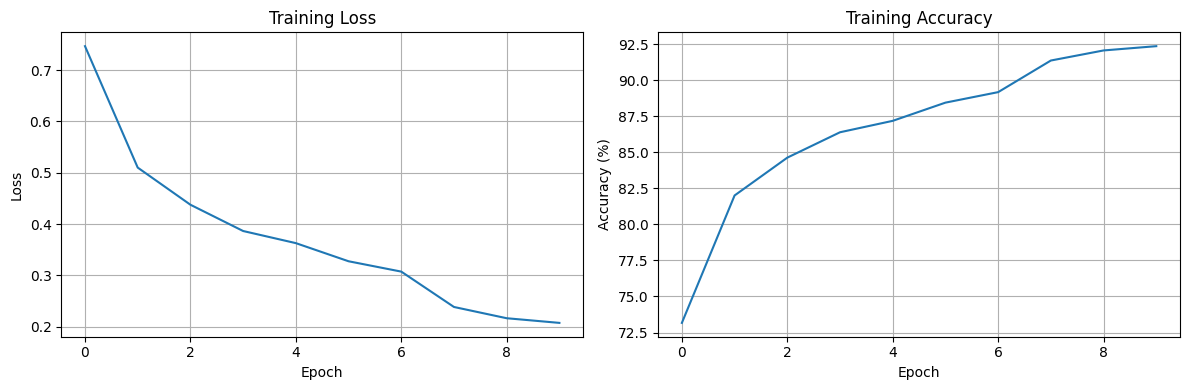

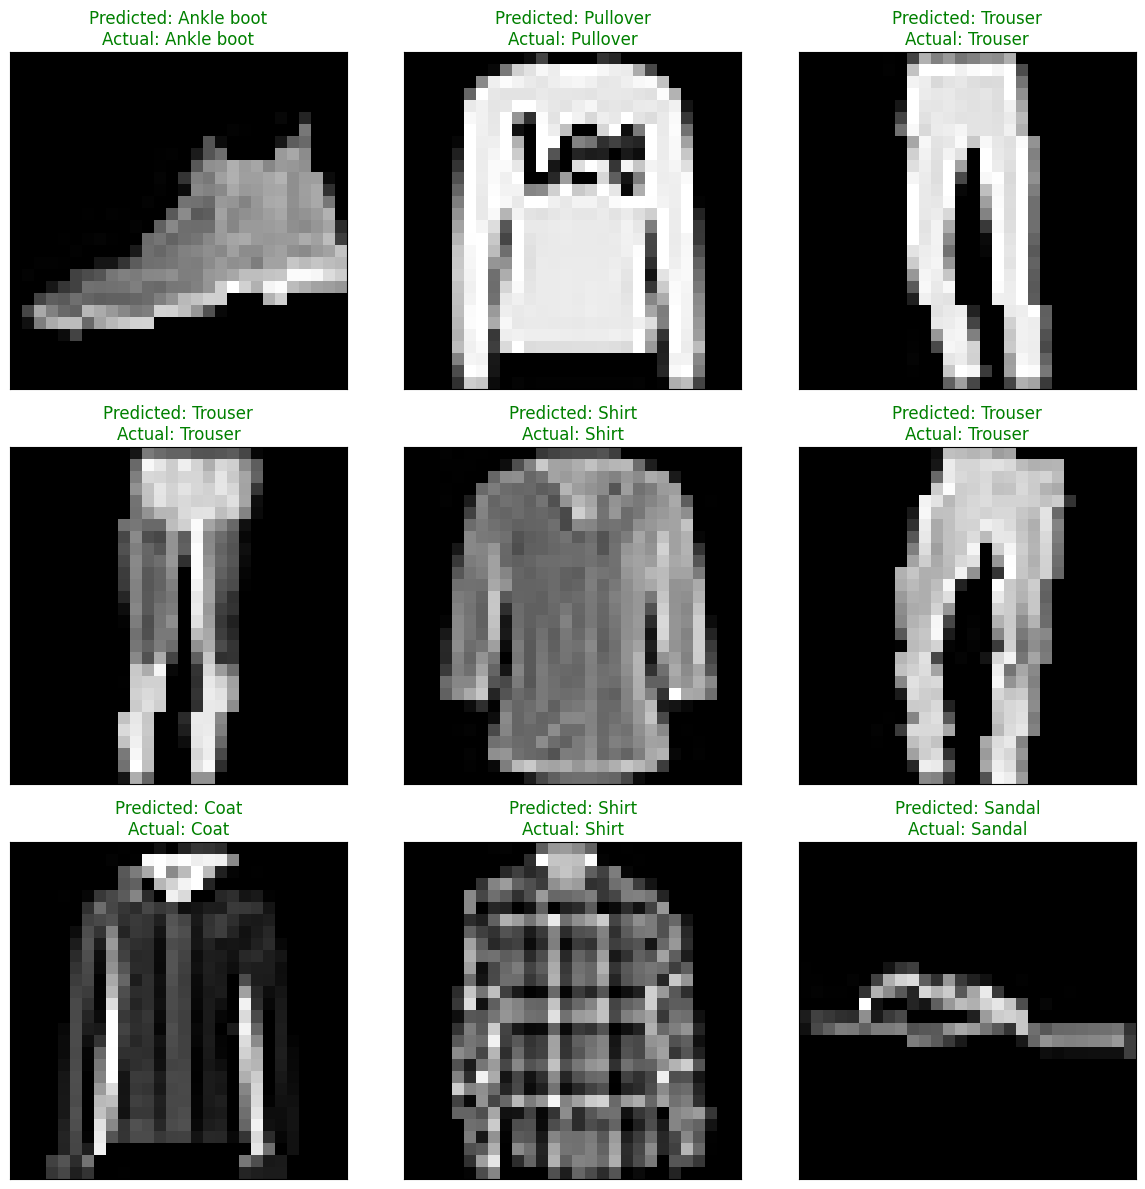

In [5]:
# Visualize training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Plot training accuracy
ax2.plot(train_accuracies)
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Visualize some predictions
def visualize_predictions(model, test_loader, num_images=9):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Move images back to CPU for visualization
    images = images.cpu()

    fig = plt.figure(figsize=(12, 12))
    for idx in range(num_images):
        ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
        # Unnormalize the image
        img = images[idx].squeeze()
        img = img * 0.5 + 0.5  # Unnormalize
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Predicted: {classes[predicted[idx]]}\nActual: {classes[labels[idx]]}",
                    color=("green" if predicted[idx]==labels[idx] else "red"))
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, test_loader, num_images=9)